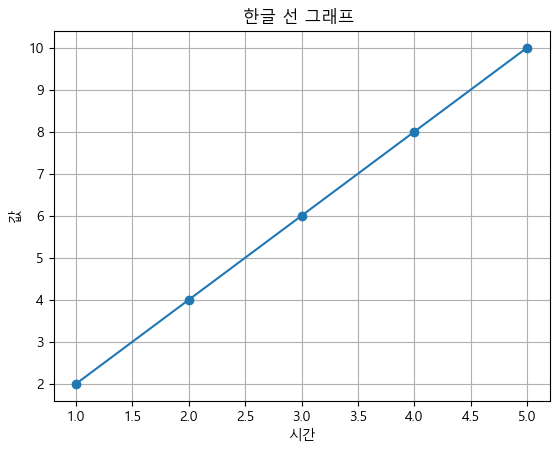

In [4]:
import matplotlib.pyplot as plt


x = [1, 2, 3, 4, 5]
y = [2, 4, 6, 8, 10]

plt.plot(x, y, marker='o')
plt.title("한글 선 그래프 ")
plt.xlabel("시간")
plt.ylabel("값")
plt.grid(True)
plt.show()
